In [2]:
import numpy as np
import itertools

import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Import my modules
from Auxiliar_Module import Auxiliar
from Models import GaussianModel

# Package for multiple precision
import mpmath as mp
mp.mp.dps = 30
print(mp.mp)

cm_in_inches = Auxiliar.cm_in_inches()

Mpmath settings:
  mp.prec = 103               [default: 53]
  mp.dps = 30                 [default: 15]
  mp.trap_complex = False     [default: False]


In [32]:
g_plot  = -10
σ_plot  = 0.05

n_basis_c    = 40
n_basis_rel  = 50
n_basis_Φ    = int(n_basis_rel/2)

nc_trunc = 30
range_iε = [0] # We only consider iε = 0 !!!!!!!!!!!

TBM_tensor = Auxiliar.TBM_tensor_calc(n_basis_c, n_basis_rel)
TBM_tensor.shape

model_plot = GaussianModel(g_plot, σ_plot, n_basis_rel, n_basis_Φ, TBM_tensor)

In [33]:
# Dict of One-coboson states
OneCobosonStates = {}
for nc in range(n_basis_c):
    for iε in range_iε: # We only consider iε = 0 !!!!!!!!!!!
        OneCobosonStates[f'B_{nc}{iε}'] = model_plot.oneCoboson(nc, iε)

# Dict of Two-coboson states with nc_1 + nc_2 < nc_trunc
TwoCobosonStates_aux = list(itertools.combinations_with_replacement(OneCobosonStates.keys(), 2))
TwoCobosonStates_dic = {}
for state in TwoCobosonStates_aux:
    state_0 = OneCobosonStates[state[0]]
    state_1 = OneCobosonStates[state[1]]
    E_sep_state = state_0.energy() + state_1.energy()
    if (state_0.n_c + state_1.n_c < nc_trunc):
        TwoCobosonStates_dic.update({state:E_sep_state})
        
TwoCobosonStates_dic = dict(sorted(TwoCobosonStates_dic.items(), key=lambda x:x[1]))
TwoCobosonStates = list(TwoCobosonStates_dic.keys())
n_BASIS = len(TwoCobosonStates)
print(f"n_BASIS = {n_BASIS}")

n_BASIS = 240


In [34]:
TwoPair_Λ = np.zeros((n_BASIS,n_BASIS))
TwoPair_S = np.zeros((n_BASIS,n_BASIS))
TwoPair_H = np.zeros((n_BASIS,n_BASIS))
TwoPair_FermionOccuMatrix = np.zeros((n_BASIS,n_BASIS,n_basis_Φ,n_basis_Φ))

# Sweeps matrices as (I,I) -> (I-1,I) -> (I-2,I) -> ... -> (0,I) for I = 0,..,n_BASIS 
for I in range(n_BASIS):
    for F in range(I,-1,-1):
        # (0,0) (0,1) ... (0,I) ... (0,N) 
        #   .   (1,1)  ^    ^    ^    ^      
        #   .     .    x    ^    ^    ^  
        #   .     .    .  (I,I)  ^    ^   
        #   .     .    .    .    x    ^    
        #   .     .    .    .    .  (N,N)
        
        f_1 = OneCobosonStates[TwoCobosonStates[F][0]]
        f_2 = OneCobosonStates[TwoCobosonStates[F][1]]
        i_1 = OneCobosonStates[TwoCobosonStates[I][0]]
        i_2 = OneCobosonStates[TwoCobosonStates[I][1]]
        
        TwoPair_Λ[F,I] = model_plot.Λ_Scatt (f_2, i_2,
                                             f_1, i_1)
        TwoPair_Λ[I,F] = TwoPair_Λ[F,I]
        
        Kronecker_δ = Auxiliar.Kronecker_δ 
        δ_FI = Kronecker_δ(f_1,i_1)*Kronecker_δ(f_2,i_2) + Kronecker_δ(f_1,i_2)*Kronecker_δ(f_2,i_1)        
        TwoPair_S[F,I] = δ_FI - TwoPair_Λ[F,I]
        
        TwoPair_H[F,I] = (i_1.energy() + i_2.energy())*TwoPair_S[F,I] \
                        + model_plot.ξ_Scatt(f_2, i_2,f_1, i_1) - model_plot.ξIn_Scatt (f_2, i_2, f_1, i_1) \
                        + model_plot.ξ_Scatt(f_1, i_2,f_2, i_1) - model_plot.ξIn_Scatt (f_1, i_2, f_2, i_1)
        
        TwoPair_FermionOccuMatrix[F,I] = model_plot.TwoCobosonSpace_FermionOccupationMatrix (f_2, i_2, f_1, i_1)
        
        norm_cte = (TwoPair_S[F,F]*TwoPair_S[I,I])**(-0.5) # Normalizing the states |I>, |F>
        
        #TwoPair_FermionOccuMatrix[F,I] = norm_cte * TwoPair_FermionOccuMatrix[F,I]
        TwoPair_FermionOccuMatrix[I,F] = TwoPair_FermionOccuMatrix[F,I]
        
        #TwoPair_S[F,I] = norm_cte * TwoPair_S[F,I]
        TwoPair_S[I,F] = TwoPair_S[F,I]
        
        #TwoPair_H[F,I] = norm_cte * TwoPair_H[F,I] # Normalizing wrt |I>, |F>
        TwoPair_H[I,F] = TwoPair_H[F,I]

Tr ρ_1 = 1.9812667311654721


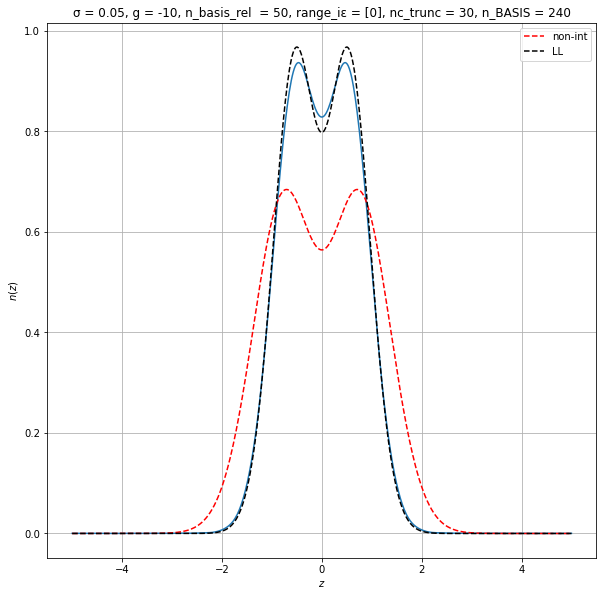

In [35]:
fig, axs = plt.subplots(1, 1,
                        sharey = True, sharex = True,
                        figsize = (25*cm_in_inches,25*cm_in_inches))

z_arr = np.linspace(-5,5,500)

ρ_1 = np.zeros((n_basis_Φ,n_basis_Φ))

# Normalized with respect to TwoPair_S
GS_coef = sp.linalg.eigh(TwoPair_H, TwoPair_S)[1][:,0]

ρ_1 = np.einsum('j,jkl',
                GS_coef,
                np.einsum('i,ijkl',
                          GS_coef,
                          TwoPair_FermionOccuMatrix))

onebody_dens_arr = Auxiliar.OneBodyDensity_from_ρ_1(ρ_1, z_arr)
axs.plot(z_arr,onebody_dens_arr)

onebody_dens_0_arr = np.array([Auxiliar.onebody_dens_0(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_0_arr, 'r--', label = 'non-int')

onebody_dens_LL_arr = np.array([Auxiliar.onebody_dens_LL(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_LL_arr, 'k--', label = 'LL')

print(f"Tr ρ_1 = {np.trace(ρ_1)}")

axs.legend()
axs.set_title(f'σ = {σ_plot}, g = {g_plot}, n_basis_rel  = {n_basis_rel}, range_iε = {range_iε}, nc_trunc = {nc_trunc}, n_BASIS = {n_BASIS}')
axs.set(xlabel='$z$')
axs.set(ylabel='$n(z)$')        
axs.grid()

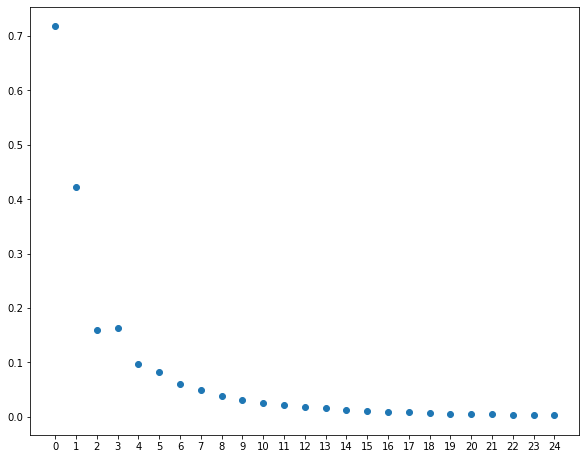

In [36]:
plt.figure(figsize = (25*cm_in_inches,20*cm_in_inches))
plt.plot(range(n_basis_Φ), ρ_1.diagonal(), 'o')
plt.xticks(range(n_basis_Φ))
plt.show()
